In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [3]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [4]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=10
latent_dimensions=16

num=4000
comps=2

beta=0.1

In [5]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp/ipykernel_8600/834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [6]:
blends_max=np.amax(blended)
blends_min=np.amin(blended)
comp_max=np.amax(components)
comp_min=np.amin(components)

blended-=blends_min
blended/=blends_max
components-=comp_min
components/=comp_max

blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

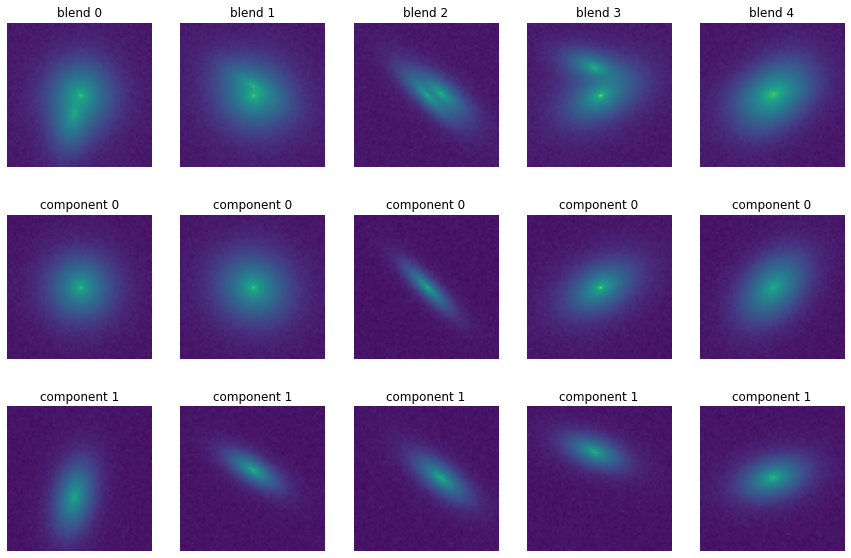

In [7]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [8]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [9]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [11]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [12]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 16)                73216     
_________________________________________________________________
functional_3 (Functional)    (None, 64, 64, 1)         106209    
Total params: 179,425
Trainable params: 179,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [15]:
history=vae.fit(components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 9s 26ms/step - loss: 6.8893 - mse_loss: 6.6389 - kl_loss: 0.2504 - val_loss: 1.4573 - val_mse_loss: 1.1955 - val_kl_loss: 0.2619
Epoch 2/100
360/360 [==============================] - 9s 25ms/step - loss: 1.0886 - mse_loss: 0.8442 - kl_loss: 0.2444 - val_loss: 0.9640 - val_mse_loss: 0.7389 - val_kl_loss: 0.2252
Epoch 3/100
360/360 [==============================] - 9s 26ms/step - loss: 0.9209 - mse_loss: 0.7056 - kl_loss: 0.2153 - val_loss: 0.8043 - val_mse_loss: 0.5986 - val_kl_loss: 0.2057
Epoch 4/100
360/360 [==============================] - 9s 25ms/step - loss: 0.8191 - mse_loss: 0.6221 - kl_loss: 0.1970 - val_loss: 0.8019 - val_mse_loss: 0.6167 - val_kl_loss: 0.1852
Epoch 5/100
360/360 [==============================] - 9s 26ms/step - loss: 0.7520 - mse_loss: 0.5672 - kl_loss: 0.1848 - val_loss: 0.7176 - val_mse_loss: 0.5404 - val_kl_loss: 0.1772
Epoch 6/100
360/360 [==============================] - 9s 26ms/step - loss: 0.72

360/360 [==============================] - 9s 24ms/step - loss: 0.5225 - mse_loss: 0.4463 - kl_loss: 0.0762 - val_loss: 0.5104 - val_mse_loss: 0.4339 - val_kl_loss: 0.0764
Epoch 46/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5116 - mse_loss: 0.4355 - kl_loss: 0.0761 - val_loss: 0.5554 - val_mse_loss: 0.4783 - val_kl_loss: 0.0771
Epoch 47/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5343 - mse_loss: 0.4578 - kl_loss: 0.0764 - val_loss: 0.6454 - val_mse_loss: 0.5658 - val_kl_loss: 0.0796
Epoch 48/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5122 - mse_loss: 0.4362 - kl_loss: 0.0760 - val_loss: 0.5264 - val_mse_loss: 0.4497 - val_kl_loss: 0.0767
Epoch 49/100
360/360 [==============================] - 9s 24ms/step - loss: 0.5107 - mse_loss: 0.4353 - kl_loss: 0.0754 - val_loss: 0.5180 - val_mse_loss: 0.4402 - val_kl_loss: 0.0779
Epoch 50/100
360/360 [==============================] - 9s 26ms/step - loss: 0.5174 - ms

360/360 [==============================] - 8s 23ms/step - loss: 0.4961 - mse_loss: 0.4243 - kl_loss: 0.0718 - val_loss: 0.5163 - val_mse_loss: 0.4455 - val_kl_loss: 0.0708
Epoch 90/100
360/360 [==============================] - 10s 28ms/step - loss: 0.4996 - mse_loss: 0.4275 - kl_loss: 0.0721 - val_loss: 0.5130 - val_mse_loss: 0.4384 - val_kl_loss: 0.0746
Epoch 91/100
360/360 [==============================] - 10s 28ms/step - loss: 0.4965 - mse_loss: 0.4247 - kl_loss: 0.0717 - val_loss: 0.4969 - val_mse_loss: 0.4249 - val_kl_loss: 0.0719
Epoch 92/100
360/360 [==============================] - 10s 28ms/step - loss: 0.4951 - mse_loss: 0.4233 - kl_loss: 0.0718 - val_loss: 0.4988 - val_mse_loss: 0.4249 - val_kl_loss: 0.0739
Epoch 93/100
360/360 [==============================] - 10s 28ms/step - loss: 0.4997 - mse_loss: 0.4284 - kl_loss: 0.0714 - val_loss: 0.5427 - val_mse_loss: 0.4715 - val_kl_loss: 0.0713
Epoch 94/100
360/360 [==============================] - 9s 25ms/step - loss: 0.5051 

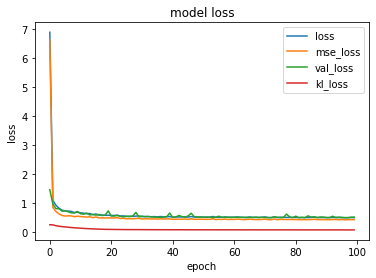

In [16]:
loss_plot(history)

In [17]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


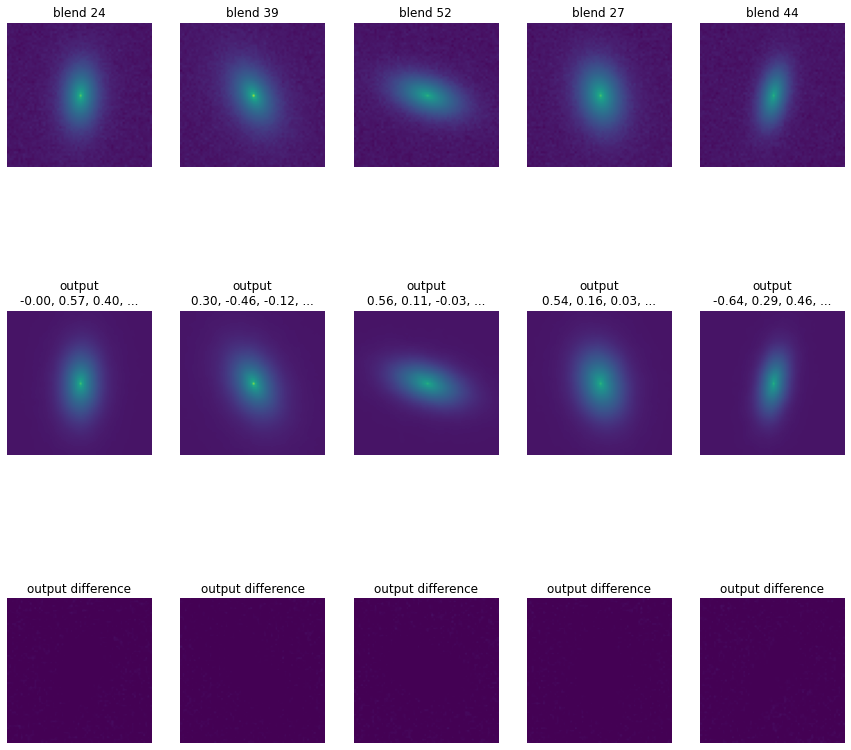

In [18]:
chosen=summary_plot(n,components[0],decode)

In [26]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [27]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode=Model([input_embed,input_compc],[output1])
decode.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_9[0][0]                   
______________________________________________________________________________________

In [28]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2,input_compc])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 16)           73216       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_15 (Functional)      (None, 64, 64, 1)    106209      functional_13[0][0]              
                                                                 input_6[0][0]        

In [29]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [30]:
history=vae.fit(together,verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 8s 22ms/step - loss: 4.8453 - mse_loss: 4.7725 - kl_loss: 0.0728 - val_loss: 3.3828 - val_mse_loss: 3.2796 - val_kl_loss: 0.1032
Epoch 2/100
360/360 [==============================] - 8s 21ms/step - loss: 2.7842 - mse_loss: 2.6956 - kl_loss: 0.0886 - val_loss: 2.7169 - val_mse_loss: 2.6368 - val_kl_loss: 0.0800
Epoch 3/100
360/360 [==============================] - 8s 21ms/step - loss: 2.2361 - mse_loss: 2.1547 - kl_loss: 0.0814 - val_loss: 2.1025 - val_mse_loss: 2.0257 - val_kl_loss: 0.0767
Epoch 4/100
360/360 [==============================] - 8s 21ms/step - loss: 1.9774 - mse_loss: 1.8997 - kl_loss: 0.0777 - val_loss: 2.0692 - val_mse_loss: 1.9859 - val_kl_loss: 0.0834
Epoch 5/100
360/360 [==============================] - 8s 21ms/step - loss: 1.7485 - mse_loss: 1.6711 - kl_loss: 0.0774 - val_loss: 1.7970 - val_mse_loss: 1.7163 - val_kl_loss: 0.0807
Epoch 6/100
360/360 [==============================] - 8s 21ms/step - loss: 1.63

360/360 [==============================] - 8s 22ms/step - loss: 0.7830 - mse_loss: 0.7111 - kl_loss: 0.0720 - val_loss: 1.1312 - val_mse_loss: 1.0583 - val_kl_loss: 0.0729
Epoch 46/100
360/360 [==============================] - 8s 21ms/step - loss: 0.7990 - mse_loss: 0.7273 - kl_loss: 0.0717 - val_loss: 1.1299 - val_mse_loss: 1.0549 - val_kl_loss: 0.0750
Epoch 47/100
360/360 [==============================] - 8s 22ms/step - loss: 0.7715 - mse_loss: 0.6993 - kl_loss: 0.0722 - val_loss: 1.1205 - val_mse_loss: 1.0458 - val_kl_loss: 0.0747
Epoch 48/100
360/360 [==============================] - 8s 22ms/step - loss: 0.7811 - mse_loss: 0.7085 - kl_loss: 0.0726 - val_loss: 1.0990 - val_mse_loss: 1.0230 - val_kl_loss: 0.0759
Epoch 49/100
360/360 [==============================] - 8s 22ms/step - loss: 0.7698 - mse_loss: 0.6968 - kl_loss: 0.0730 - val_loss: 1.2021 - val_mse_loss: 1.1239 - val_kl_loss: 0.0782
Epoch 50/100
360/360 [==============================] - 8s 22ms/step - loss: 0.7569 - ms

360/360 [==============================] - 9s 24ms/step - loss: 0.6488 - mse_loss: 0.5769 - kl_loss: 0.0718 - val_loss: 1.0873 - val_mse_loss: 1.0143 - val_kl_loss: 0.0731
Epoch 90/100
360/360 [==============================] - 8s 23ms/step - loss: 0.6371 - mse_loss: 0.5654 - kl_loss: 0.0717 - val_loss: 1.1881 - val_mse_loss: 1.1107 - val_kl_loss: 0.0774
Epoch 91/100
360/360 [==============================] - 9s 24ms/step - loss: 0.6600 - mse_loss: 0.5875 - kl_loss: 0.0725 - val_loss: 1.1060 - val_mse_loss: 1.0369 - val_kl_loss: 0.0691
Epoch 92/100
360/360 [==============================] - 9s 24ms/step - loss: 0.6420 - mse_loss: 0.5699 - kl_loss: 0.0721 - val_loss: 1.1408 - val_mse_loss: 1.0698 - val_kl_loss: 0.0710
Epoch 93/100
360/360 [==============================] - 9s 24ms/step - loss: 0.6298 - mse_loss: 0.5579 - kl_loss: 0.0719 - val_loss: 1.1243 - val_mse_loss: 1.0562 - val_kl_loss: 0.0681
Epoch 94/100
360/360 [==============================] - 8s 23ms/step - loss: 0.6454 - ms

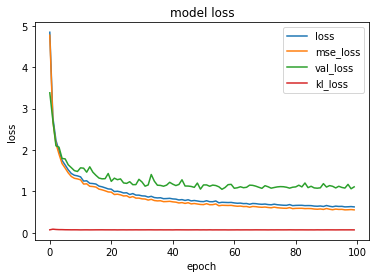

In [31]:
loss_plot(history)

In [37]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode2.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')
    return idx

[ 200 1078  610 2159 1169]


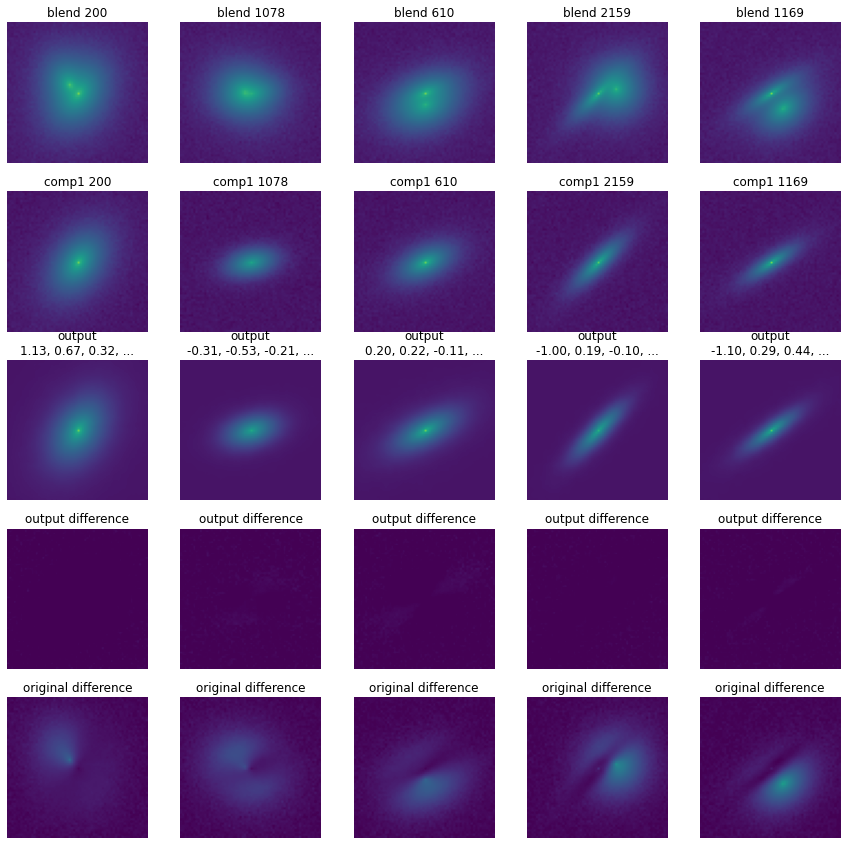

In [38]:
chosen=summary_plot(n,together,decode)

(Text(0.5, 0, 'Loss'), Text(0, 0.5, 'Frequency'))

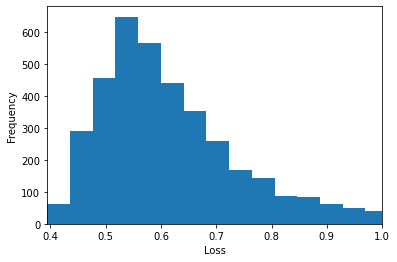

In [39]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=0,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
loss_max=np.amax(losses)
loss_min=np.amin(losses)
ax=plt.axes()
ax.hist(losses,bins=500)
ax.set_xlim(max(loss_min,0),min(loss_max,1)),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")

In [36]:
vae.save_weights("model_1.h5")
decode.save_weights("decoder_1.h5")

In [ ]:
#vae=Model.load_weights("model_1.h5")
#vae.summary()